In [46]:
import numpy  as np
import pandas as pd

import antea.database.load_db      as db
import antea.reco.reco_functions   as rf
import antea.reco.mctrue_functions as mcf

import matplotlib.pyplot as plt

from antea.io.mc_io import load_mcsns_response
from antea.io.mc_io import load_mchits
from antea.io.mc_io import load_mcparticles

%matplotlib nbagg

### npz with extracted events from full MC

In [15]:
coincPath          = '/Users/carmenromoluque/nexus_petit_analysis/full-body-PET/nest/data_extract_coinc_phantom/'
file_extract_coinc = coincPath  + 'full_body_extract_coinc_nest_phot_info_dist_tof_2000_10_2_4_4_2.npz'

d        = np.load(file_extract_coinc)
df_coinc = pd.DataFrame({})
for (key, vals) in d.items():
    if key=='a_first_sipm1_thrs':
        df_coinc['first_sipm1_thr0'] = vals[0]
        df_coinc['first_sipm1_thr1'] = vals[1]
        df_coinc['first_sipm1_thr2'] = vals[2]
        df_coinc['first_sipm1_thr3'] = vals[3]
    elif key=='a_first_sipm2_thrs':
        df_coinc['first_sipm2_thr0'] = vals[0]
        df_coinc['first_sipm2_thr1'] = vals[1]
        df_coinc['first_sipm2_thr2'] = vals[2]
        df_coinc['first_sipm2_thr3'] = vals[3]
    elif key=='a_first_time1_thrs':
        df_coinc['first_time1_thr0'] = vals[0]
        df_coinc['first_time1_thr1'] = vals[1]
        df_coinc['first_time1_thr2'] = vals[2]
        df_coinc['first_time1_thr3'] = vals[3]
    elif key=='a_first_time2_thrs':
        df_coinc['first_time2_thr0'] = vals[0]
        df_coinc['first_time2_thr1'] = vals[1]
        df_coinc['first_time2_thr2'] = vals[2]
        df_coinc['first_time2_thr3'] = vals[3]
    else:
        df_coinc[key[2:]] = vals

print(len(df_coinc))

2714


### Fast MC

In [42]:
fastMCPath = '/Users/carmenromoluque/nexus_petit_analysis/full-body-PET/nest/data_fastsim_phantom/'

thrs = ['0', '0.5', '1.0', '1.5']
cols = ['event_id', 'true_energy', 
        'true_r1', 'true_phi1', 'true_z1', 'true_t1', 
        'true_r2', 'true_phi2', 'true_z2', 'true_t2', 'phot_like1', 'phot_like2',
        'reco_r1', 'reco_phi1', 'reco_z1', 'reco_t1',
        'reco_r2', 'reco_phi2', 'reco_z2', 'reco_t2']

## We only take the events with energy above the energy threshold
df_fast_all_0 = pd.DataFrame(columns=cols)
df_fast_all_1 = pd.DataFrame(columns=cols)
df_fast_all_2 = pd.DataFrame(columns=cols)
df_fast_all_3 = pd.DataFrame(columns=cols)

for th in thrs:
    filename  = f'full_body_phantom_nest_reco_thr{th}pes.2000.h5'
    file_fast = fastMCPath+filename
    table = pd.read_hdf(file_fast, 'reco/table')
    sel_below_th = (table.true_energy > 0.) & (table.true_r1 == 0.)
    reco = table[~sel_below_th]
    if th == '0':
        df_fast_all_0 = pd.concat([df_fast_all_0, reco], ignore_index=True)
    elif th == '0.5':
        df_fast_all_1 = pd.concat([df_fast_all_1, reco], ignore_index=True)
    elif th == '1.0':
        df_fast_all_2 = pd.concat([df_fast_all_2, reco], ignore_index=True)
    elif th == '1.5':
        df_fast_all_3 = pd.concat([df_fast_all_3, reco], ignore_index=True)

### Plot hits of the selected event

<IPython.core.display.Javascript object>


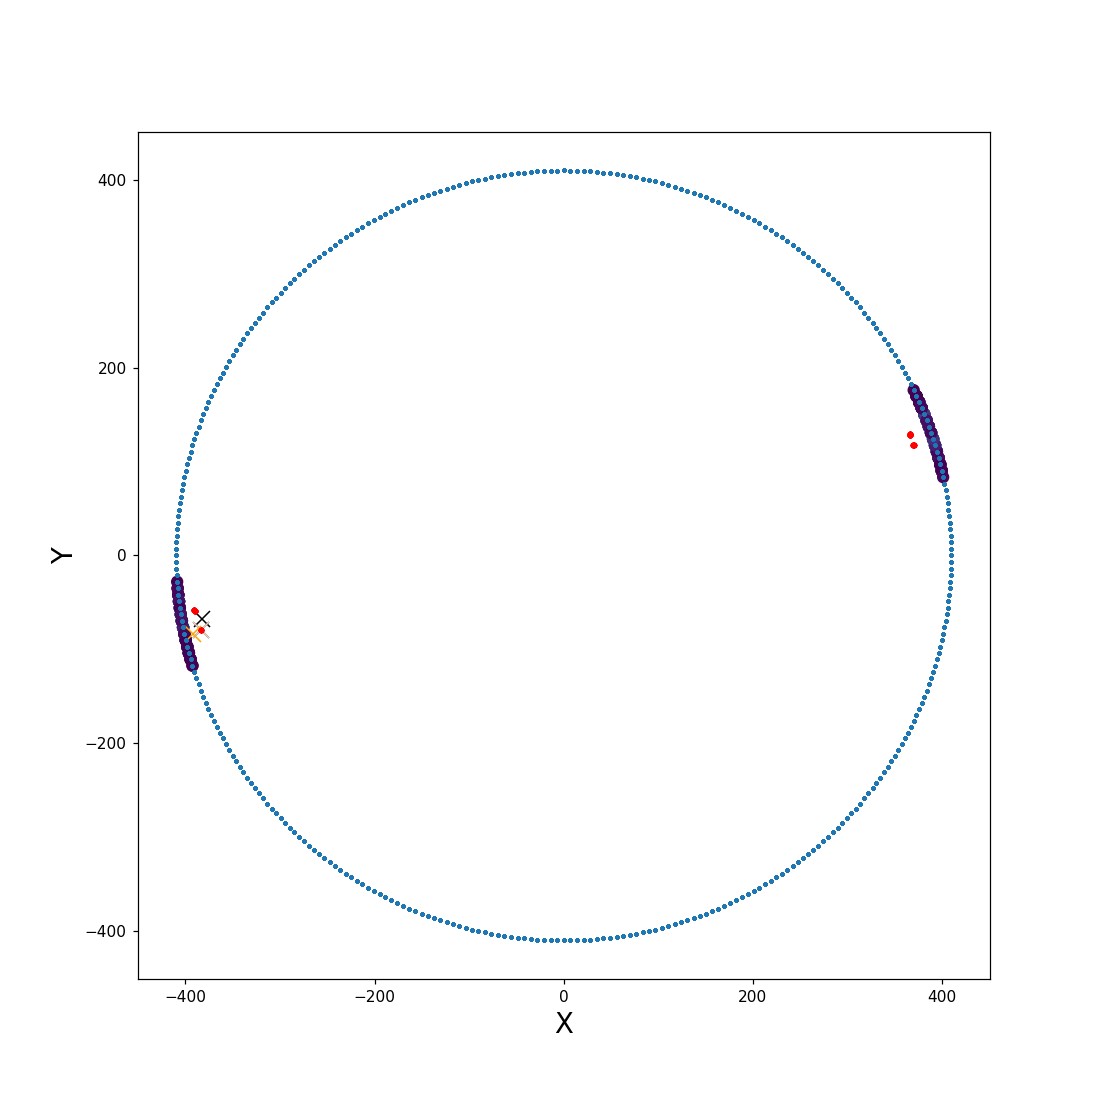

In [59]:
### read sensor positions from database
DataSiPM     = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx = DataSiPM.set_index('SensorID')

eventsPath         = '/Users/carmenromoluque/nexus_petit_analysis/full-body-PET/nest/'
file_full          = eventsPath + 'full_body_phantom_nest.2000.pet.h5'

threshold    = 2
sns_response = load_mcsns_response(file_full)
sel_df       = rf.find_SiPMs_over_threshold(sns_response, threshold)

hits      = load_mchits     (file_full)
particles = load_mcparticles(file_full)
events    = particles.event_id.unique()

selected_event = 266
for evt in events[selected_event:selected_event+1]:
    evt_parts = particles[particles.event_id == evt]
    evt_hits  = hits     [hits     .event_id == evt]
    
    coinc_evt   = df_coinc     [df_coinc     .event_ids == evt]
    fastmc0_evt = df_fast_all_0[df_fast_all_0.event_id  == evt]
    fastmc1_evt = df_fast_all_1[df_fast_all_1.event_id  == evt]
    fastmc2_evt = df_fast_all_2[df_fast_all_2.event_id  == evt]
    fastmc3_evt = df_fast_all_3[df_fast_all_3.event_id  == evt]        
    
    plt.figure(figsize=(10,10))
    plot_xy_reco_true_from_df(  coinc_evt, plot_only_one_evt=True)
    #plot_xy_reco_true_from_df(fastmc0_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)
    plot_xy_reco_true_from_df(fastmc1_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)
    #plot_xy_reco_true_from_df(fastmc2_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)
    #plot_xy_reco_true_from_df(fastmc3_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)

    #select, true_pos = mcf.select_photoelectric(evt_parts, evt_hits)
    waveforms  = sel_df[sel_df.event_id == evt]
    _, pos, qs = pos_charges(waveforms, DataSiPM_idx)

    pos_x = np.array([el[0] for el in pos])
    pos_y = np.array([el[1] for el in pos])
    pos_z = np.array([el[2] for el in pos])
    
    plt.scatter(pos_x, pos_y, c=qs, marker='o', s=50)
    plt.xlabel('X', size=18)
    plt.ylabel('Y', size=18)
    
    pos1_x = evt_hits.x
    pos1_y = evt_hits.y
    pos1_z = evt_hits.z
    plt.plot(pos1_x, pos1_y, '.', c='r', markersize=5)
    
    plt.plot(DataSiPM.X.values, DataSiPM.Y.values, '.', markersize=3)
    #plt.xlim(-420, -350)
    #plt.ylim(-150, 150)

### Plot in YZ

<IPython.core.display.Javascript object>


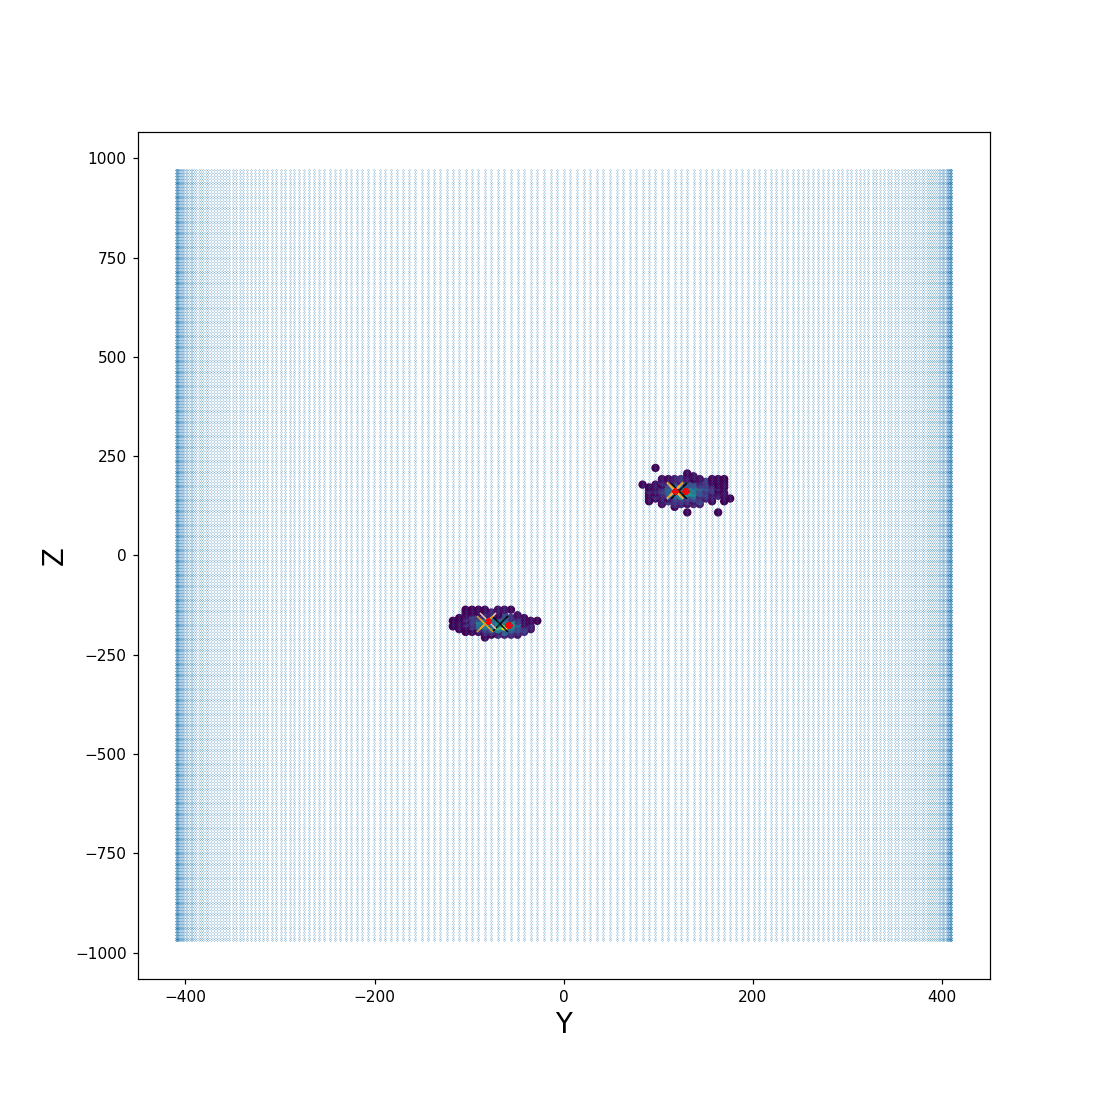

In [65]:
plt.figure(figsize=(10,10))
plot_yz_reco_true_from_df(  coinc_evt, plot_only_one_evt=False)
#plot_xy_reco_true_from_df(fastmc0_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)
plot_yz_reco_true_from_df(fastmc1_evt, color_true='pink', color_reco='orange', plot_only_one_evt=False)
#plot_xy_reco_true_from_df(fastmc2_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)
#plot_xy_reco_true_from_df(fastmc3_evt, color_true='pink', color_reco='orange', plot_only_one_evt=True)

plt.scatter(pos_y, pos_z, c=qs, marker='o', s=20)
plt.xlabel('Y', size=18)
plt.ylabel('Z', size=18)

plt.plot(pos1_y, pos1_z, '.', c='r', markersize=5)

plt.plot(DataSiPM.Y.values, DataSiPM.Z.values, '.', markersize=0.2);
#plt.xlim(-420, -350)
#plt.ylim(-150, 150)

In [18]:
def pos_charges(sns_response, DataSiPM_idx):
    sipms   = DataSiPM_idx.loc[sns_response.sensor_id]
    sns_ids = sipms.index.astype('int64').values

    q   = []
    pos = []
    ids = []

    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges   = sns_response.charge
    for sns_id, sns_pos, charge in zip(sns_ids, sns_positions, sns_charges):
        q  .append(charge)
        pos.append(sns_pos)
        ids.append(sns_id)

    return ids, pos, q

In [29]:
def cart_coord_from_df(df):
    true_x1 = df.true_r1 * np.cos(df.true_phi1)
    reco_x1 = df.reco_r1 * np.cos(df.reco_phi1)
    true_y1 = df.true_r1 * np.sin(df.true_phi1)
    reco_y1 = df.reco_r1 * np.sin(df.reco_phi1)
    true_x2 = df.true_r2 * np.cos(df.true_phi2)
    reco_x2 = df.reco_r2 * np.cos(df.reco_phi2)
    true_y2 = df.true_r2 * np.sin(df.true_phi2)
    reco_y2 = df.reco_r2 * np.sin(df.reco_phi2)
    return true_x1, reco_x1, true_y1, reco_y1, true_x2, reco_x2, true_y2, reco_y2

In [50]:
def plot_xy_reco_true_from_df(df, color_true='g', color_reco='k', plot_only_one_evt=False):
    true_x1 = df.true_r1 * np.cos(df.true_phi1)
    reco_x1 = df.reco_r1 * np.cos(df.reco_phi1)
    true_y1 = df.true_r1 * np.sin(df.true_phi1)
    reco_y1 = df.reco_r1 * np.sin(df.reco_phi1)
    true_x2 = df.true_r2 * np.cos(df.true_phi2)
    reco_x2 = df.reco_r2 * np.cos(df.reco_phi2)
    true_y2 = df.true_r2 * np.sin(df.true_phi2)
    reco_y2 = df.reco_r2 * np.sin(df.reco_phi2)
    
    if plot_only_one_evt:
        plt.plot(true_x1, true_y1, 'x', c=color_true, markersize=10)
        plt.plot(reco_x1, reco_y1, 'x', c=color_reco, markersize=10)
    else:
        plt.plot(true_x1, true_y1, 'x', c=color_true, markersize=10)
        plt.plot(reco_x1, reco_y1, 'x', c=color_reco, markersize=10)
        plt.plot(true_x2, true_y2, 'x', c=color_true, markersize=10)
        plt.plot(reco_x2, reco_y2, 'x', c=color_reco, markersize=10)
    return true_x1, reco_x1, true_y1, reco_y1, true_x2, reco_x2, true_y2, reco_y2

In [55]:
def plot_yz_reco_true_from_df(df, color_true='g', color_reco='k', plot_only_one_evt=False):
    true_y1 = df.true_r1 * np.sin(df.true_phi1)
    reco_y1 = df.reco_r1 * np.sin(df.reco_phi1)
    true_z1 = df.true_z1
    reco_z1 = df.reco_z1
    true_y2 = df.true_r2 * np.sin(df.true_phi2)
    reco_y2 = df.reco_r2 * np.sin(df.reco_phi2)
    true_z2 = df.true_z2
    reco_z2 = df.reco_z2
    
    if plot_only_one_evt:
        plt.plot(true_y1, true_z1, 'x', c=color_true, markersize=10)
        plt.plot(reco_y1, reco_z1, 'x', c=color_reco, markersize=10)
    else:
        plt.plot(true_y1, true_z1, 'x', c=color_true, markersize=10)
        plt.plot(reco_y1, reco_z1, 'x', c=color_reco, markersize=10)
        plt.plot(true_y2, true_z2, 'x', c=color_true, markersize=10)
        plt.plot(reco_y2, reco_z2, 'x', c=color_reco, markersize=10)
    return true_y1, reco_y1, true_z1, reco_z1, true_y2, reco_y2, true_z2, reco_z2

In [73]:
print(df_coinc   [df_coinc   .event_ids==evt].true_phi2.values)
print(fastmc0_evt[fastmc0_evt.event_id ==evt].true_phi2.values)
print(fastmc1_evt[fastmc1_evt.event_id ==evt].true_phi2.values)
print(fastmc2_evt[fastmc2_evt.event_id ==evt].true_phi2.values)
print(fastmc3_evt[fastmc3_evt.event_id ==evt].true_phi2.values)

[0.3081346]
[0.30813459]
[0.30813459]
[0.30813459]
[0.30813459]


In [ ]:
h=plt.hist(df_full.true_phi2 - nest_true_phi2_fast_1,  bins=150, range=(-6, 6), alpha=0.5, label='nest' );
h=plt.hist(df_full_nexus.true_phi2 - nexus_true_phi2_fast_1, bins=150, range=(-6, 6), alpha=0.5, label='nexus');
plt.yscale('log')
plt.legend();